In [2]:
using LinearAlgebra;
using StaticArrays;
using Makie
using Makie:Point2f0
using CairoMakie
using Printf
using Symbolics
using PlotlyJS
using Brillouin


## Construction of the Hamiltonian -- Both spin states are included in the lattice Hamiltonian

In [3]:
# Here, we define the three vectors connecting nearest neighbor Kagome atoms 

# Useful C_3 rotation
global const C_3::Matrix{Float64} = [cos(2.0*pi/3.0) -sin(2.0*pi/3.0); sin(2.0*pi/3.0) cos(2.0*pi/3.0)]

# Useful C_6 rotation
global const C_6::Matrix{Float64} = [cos(pi/3.0) -sin(pi/3.0); sin(pi/3.0) cos(pi/3.0)]


# Nearest neighbor vectors 
global const A1::Vector{Float64} = [1.0, 0.0]
global const A2::Vector{Float64} = [0.5, 0.5 * sqrt(3.0)]
global const A3::Vector{Float64} = A2 - A1; 


# Useful in constructing the Kagome Hamiltonian 
global const λ0  = @SArray ComplexF64[1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]

global const T1u  = @SArray ComplexF64[0.0 1.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
global const T2u  = @SArray ComplexF64[0.0 0.0 1.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
global const T3u  = @SArray ComplexF64[0.0 0.0 0.0; 0.0 0.0 1.0; 0.0 0.0 0.0];

global const s1  = @SArray ComplexF64[0.0 1.0; 1.0 0.0]
global const s2  = @SArray ComplexF64[0.0 -im; im 0.0]
global const s3  = @SArray ComplexF64[1.0 0.0; 0.0 -1.0];
global const s0  = @SArray ComplexF64[1.0 0.0; 0.0 1.0];


global const s_up  = @SArray ComplexF64[1.0 0.0; 0.0 0.0];
global const s_dn  = @SArray ComplexF64[0.0 0.0; 0.0 1.0];


# Reciprocal and Direct Lattice 
global const R1::Vector{Float64} = 2.0 * A1 
global const R2::Vector{Float64} = 2.0 * A2

global const R::Matrix{Float64} = [R1 R2]';
global const G::Matrix{Float64} = 2.0 * pi * inv(R');

# Kagome Model 
### Instead of the coupling constants t, u ---> complex (but hermitian) coupling matrices, since we now have both spin states  
@inline function H_Kagome(k::Vector{Float64}, t1::Float64, t2::Float64, u1::Float64, u2::Float64, B::Float64 = 0.0)
    Φ1::ComplexF64 = 2.0 * ((-t1 + im * u1) * cos(kx) + (-t2 + im * u2) * cos(sqrt(3.0) * ky)) 
    Φ2::ComplexF64 = 2.0 * ((-t1 - im * u1) * cos(0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 + im * u2) * cos(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
    Φ3::ComplexF64 = 2.0 * ((-t1 + im * u1) * cos(-0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 - im * u2) * cos(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 

    kron(Φ1 * s_up + conj(Φ1 * s_dn), T1u) +  kron(Φ2 * s_up + conj(Φ2 * s_dn), T2u) +  kron(Φ3 * s_up + conj(Φ3 * s_dn), T3u) + B * kron(s3, λ0)
 end

 @inline function evals(k::Vector{Float64}, t1::Float64, t2::Float64, u1::Float64, u2::Float64, B::Float64 = 0.0)
   kx::Float64 = k[1]; ky::Float64 = k[2]
   Φ1::ComplexF64 = 2.0 * ((-t1 + im * u1) * cos(kx) + (-t2 + im * u2) * cos(sqrt(3.0) * ky)) 
   Φ2::ComplexF64 = 2.0 * ((-t1 - im * u1) * cos(0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 + im * u2) * cos(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
   Φ3::ComplexF64 = 2.0 * ((-t1 + im * u1) * cos(-0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 - im * u2) * cos(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 

   H::Matrix{ComplexF64} = kron(Φ1 * s_up + conj(Φ1 * s_dn), T1u) +  kron(Φ2 * s_up + conj(Φ2 * s_dn), T2u) +  kron(Φ3 * s_up + conj(Φ3 * s_dn), T3u) + B * kron(s3, λ0)
   eigvals(Hermitian(H + H'))
end


@inline function eigensystem_kagome(k::Vector{Float64}, t1::Float64, t2::Float64, u1::Float64, u2::Float64, B::Float64 = 0.0)
   kx::Float64 = k[1]; ky::Float64 = k[2]
   Φ1::ComplexF64 = 2.0 * ((-t1 + im * u1) * cos(kx) + (-t2 + im * u2) * cos(sqrt(3.0) * ky)) 
   Φ2::ComplexF64 = 2.0 * ((-t1 - im * u1) * cos(0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 + im * u2) * cos(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
   Φ3::ComplexF64 = 2.0 * ((-t1 + im * u1) * cos(-0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 - im * u2) * cos(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 

   H::Matrix{ComplexF64} = kron(Φ1 * s_up + conj(Φ1 * s_dn), T1u) +  kron(Φ2 * s_up + conj(Φ2 * s_dn), T2u) +  kron(Φ3 * s_up + conj(Φ3 * s_dn), T3u) + B * kron(s3, λ0)
   eigen(Hermitian(H + H'))
end


@inline function Vx(k::Vector{Float64}, t1::Float64, t2::Float64, u1::Float64, u2::Float64)
    kx::Float64 = k[1]; ky::Float64 = k[2]
    dΦ1_dx::ComplexF64 = -2.0 * ((-t1 + im * u1) * sin(kx))
    dΦ2_dx::ComplexF64 = 2.0 * (-(-t1 - im * u1) * sin(0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 + im * u2) * 1.5 * sin(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
    dΦ3_dx::ComplexF64 = 2.0 * (0.5 * (-t1 + im * u1) * sin(-0.5 * kx + 0.5 * sqrt(3.0) * ky) - 1.5 * (-t2 - im * u2) * sin(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
    m::Matrix{ComplexF64} = kron(dΦ1_dx * s_up + conj(dΦ1_dx * s_dn), T1u) +  kron(dΦ2_dx * s_up + conj(dΦ2_dx * s_dn), T2u) +  kron(dΦ3_dx * s_up + conj(dΦ3_dx * s_dn), T3u)
    m + m'
end

@inline function Vy(k::Vector{Float64}, t1::Float64, t2::Float64, u1::Float64, u2::Float64)
    kx::Float64 = k[1]; ky::Float64 = k[2]
    dΦ1_dy::ComplexF64 = -sqrt(3.0) * (-t2 + im * u2) * sin(sqrt(3.0) * ky)
    dΦ2_dy::ComplexF64 = sqrt(3.0) * (-(-t1 - im * u1) * sin(0.5 * kx + 0.5 * sqrt(3.0) * ky) - (-t2 + im * u2) * sin(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
    dΦ3_dy::ComplexF64 = sqrt(3.0) * (-(-t1 + im * u1) * sin(-0.5 * kx + 0.5 * sqrt(3.0) * ky) - (-t2 - im * u2) * sin(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
    m::Matrix{ComplexF64} = kron(dΦ1_dy * s_up + conj(dΦ1_dy * s_dn), T1u) +  kron(dΦ2_dy * s_up + conj(dΦ2_dy * s_dn), T2u) +  kron(dΦ3_dy * s_up + conj(dΦ3_dy * s_dn), T3u)
    m + m'
end;

@inline function calculate_kgrid(; G::Matrix{Float64} = G, nps::Int = 400)
    """
    Calculate a regular grid in the FBZ 
    """
    G1::Vector{Float64} = G[1, :]; G2::Vector{Float64} = G[2, :]
    kgrid = Matrix{Vector{Float64}}(undef, nps, nps)
    for n ∈ 1 : nps
        for m ∈ 1 : nps
            kgrid[n, m] = ((n - 1) * G1 + (m - 1) * G2) / nps
        end
    end
    kgrid
end

@inline function Berry_Curvature(k::Vector{Float64},
    t1::Float64, 
    t2::Float64, 
    u1::Float64, 
    u2::Float64, 
    B::Float64 = 0.0,
    band::Int = 1)

    (E, U) = eigensystem_kagome(k, t1, t2, u1, u2, B)
    Vxb::Matrix{ComplexF64} = U' * Vx(k, t1, t2, u1, u2) * U
    Vyb::Matrix{ComplexF64} = U' * Vy(k, t1, t2, u1, u2) * U

    bck::Float64 = 0.0

    for n ∈ 1:3
        if (n != band)
            bck += 2.0 * imag(Vxb[band, n] * Vyb[n, band]) / (E[band] - E[n])^2
        end
    end
    return bck
end

@inline function Quantum_Metric_xy(k::Vector{Float64},
    t1::Float64, 
    t2::Float64, 
    u1::Float64, 
    u2::Float64,
    B::Float64 = 0.0,
    band::Int = 1)

    (E, U) = eigensystem_kagome(k, t1, t2, u1, u2, B)
    Vxb::Matrix{ComplexF64} = U' * Vx(k, t1, t2, u1, u2) * U
    Vyb::Matrix{ComplexF64} = U' * Vy(k, t1, t2, u1, u2) * U

    bck::Float64 = 0.0

    for n ∈ 1:3
        if (n != band)
            bck += real(Vxb[band, n] * Vyb[n, band]) / (E[band] - E[n])^2
        end
    end
    return bck
end

@inline function Quantum_Metric_xx(k::Vector{Float64},
    t1::Float64, 
    t2::Float64, 
    u1::Float64, 
    u2::Float64, 
    B::Float64 = 0.0,
    band::Int = 1)

    (E, U) = eigensystem_kagome(k, t1, t2, u1, u2, B)
    Vxb::Matrix{ComplexF64} = U' * Vx(k, t1, t2, u1, u2) * U
    
    bck::Float64 = 0.0

    for n ∈ 1:3
        if (n != band)
            bck += real(Vxb[band, n] * Vxb[n, band]) / (E[band] - E[n])^2
        end
    end
    return bck
end

@inline function Quantum_Metric_yy(k::Vector{Float64},
    t1::Float64, 
    t2::Float64, 
    u1::Float64, 
    u2::Float64, 
    B::Float64 = 0.0,
    band::Int = 1)

    (E, U) = eigensystem_kagome(k, t1, t2, u1, u2, B)
    Vxb::Matrix{ComplexF64} = U' * Vy(k, t1, t2, u1, u2) * U
    
    bck::Float64 = 0.0

    for n ∈ 1:3
        if (n != band)
            bck += real(Vyb[band, n] * Vyb[n, band]) / (E[band] - E[n])^2
        end
    end
    return bck
end


Quantum_Metric_yy (generic function with 3 methods)

In [4]:
"""
    plot_band_structure(M::Float64)
    Plot the band structure of the Kagome model
"""
function plot_bands3D_Kagome(;t1::Float64, t2::Float64, u1::Float64, u2::Float64, B::Float64 = 0.0, seedname::String = "Kagome_", title::String = "Kagome Model")
    # construction of the grid 
    npts_perdim = 300
    rng = LinRange(-pi, pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end    


    E = evals.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(B))
    ek_1 = map(x -> x[1], E)
    ek_2 = map(x -> x[2], E)
    ek_3 = map(x -> x[3], E)
    ek_4 = map(x -> x[4], E)
    ek_5 = map(x -> x[5], E)
    ek_6 = map(x -> x[6], E)
    
    kxs = reshape(map(e->e[1], grid), (npts_perdim, npts_perdim))
    kys = reshape(map(e->e[2], grid), (npts_perdim, npts_perdim))

    f = Figure()
    ax = Axis3(f[1, 1], title = title * " , t1 = $t1, t2 = $t2, u1 = $u1, u2 = $u2", elevation = pi / 40.0)


    Makie.surface!(ax, kxs, kys, ek_1, colormap = :viridis)
    Makie.surface!(ax, kxs, kys, ek_2, colormap = :viridis)
    Makie.surface!(ax, kxs, kys, ek_3, colormap = :viridis)
    Makie.surface!(ax, kxs, kys, ek_4, colormap = :viridis)
    Makie.surface!(ax, kxs, kys, ek_5, colormap = :viridis)
    Makie.surface!(ax, kxs, kys, ek_6, colormap = :viridis)
    ax.xlabel = L"k_x"
    ax.ylabel = L"k_y"
    #Makie.save(assets_dir * seedname * "M=$M" * ".png", f)
    display(f)
end

plot_bands3D_Kagome

### We note that even with spin-orbit coupling, each band is 2-Fold degenerate if we switch off the background magnetic field. This is Kramer's degeneracy of the bands. 

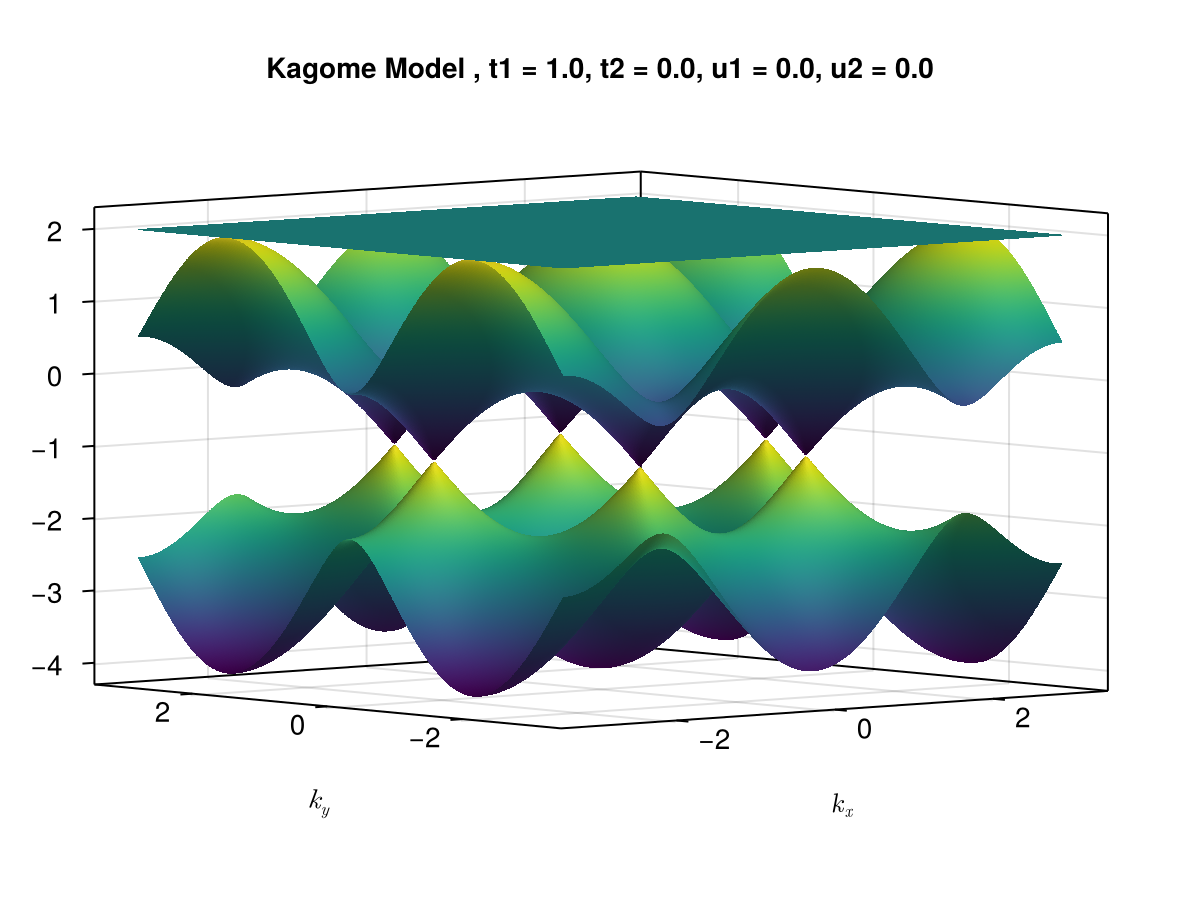

CairoMakie.Screen{IMAGE}


In [5]:
plot_bands3D_Kagome(t1 = 1.0, t2 = 0.0, u1 = 0.0, u2 = 0.0)

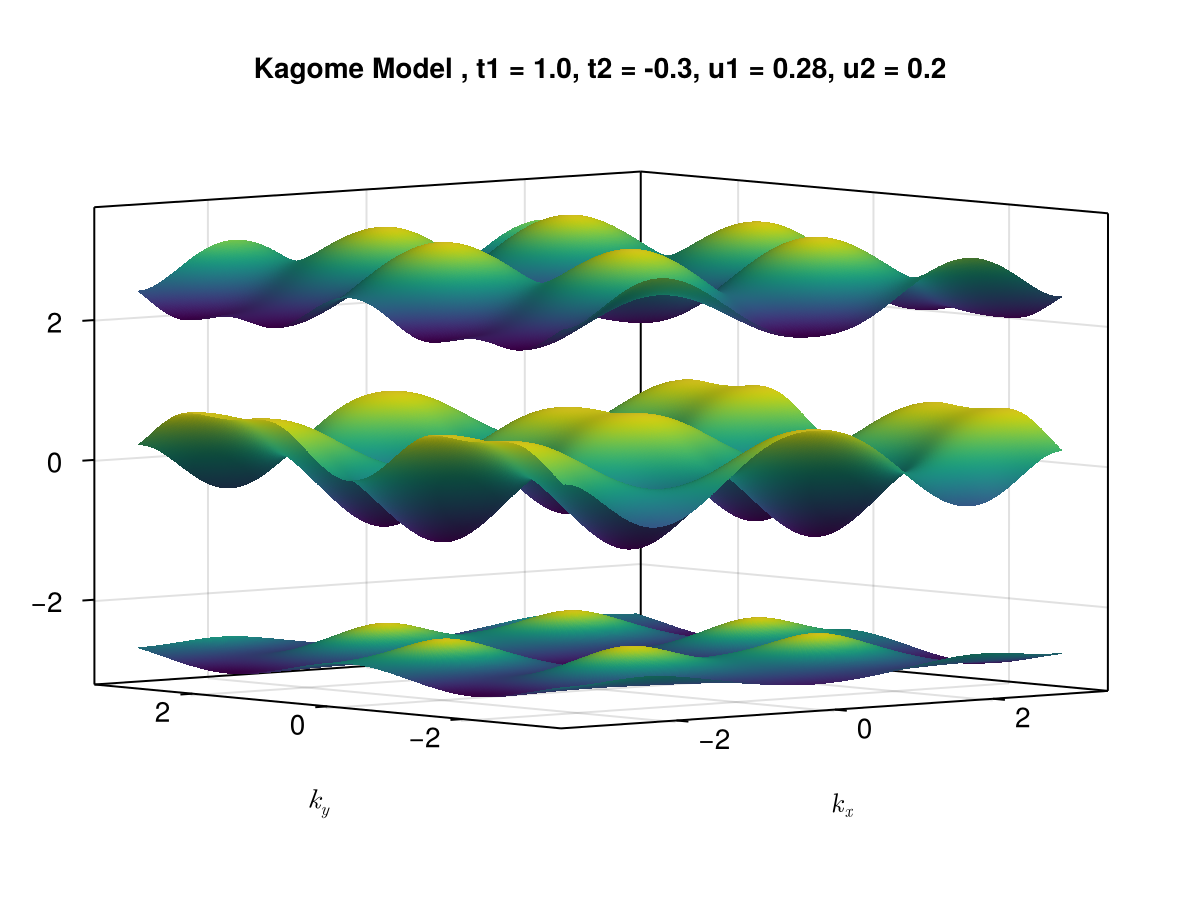

CairoMakie.Screen{IMAGE}


In [6]:
plot_bands3D_Kagome(t1 = 1.0, t2 = -0.3, u1 = 0.28, u2 = 0.2)

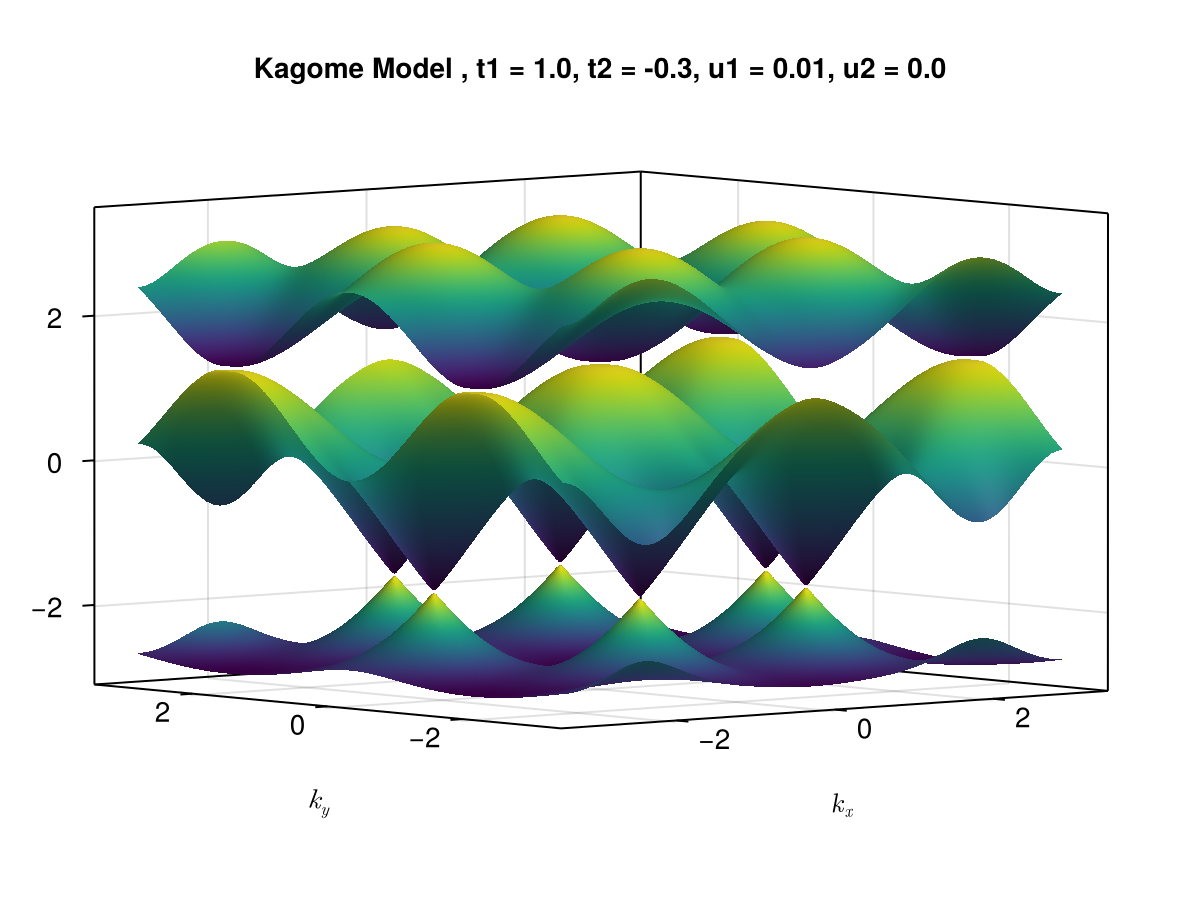

CairoMakie.Screen{IMAGE}


In [7]:
plot_bands3D_Kagome(t1 = 1.0, t2 = -0.3, u1 = 0.01, u2 = 0.0)

#### 2D Band Structure Plots 

--- Plotting the Wigner-Seitz cell in reciprocal space. 

--- Vertices of the reciprocal Wigner-Seitz cell (in reduced coordinates): 
 -0.333333   0.333333 
 -0.666667  -0.333333 
 -0.333333  -0.666667 
  0.333333  -0.333333 
  0.666667   0.333333 
  0.333333   0.666667 

--- Vertices of the reciprocal Wigner-Seitz cell (in cartesian coordinates): 
 -1.047198   1.813799 
 -2.094395   0.000000 
 -1.047198  -1.813799 
  1.047198  -1.813799 
  2.094395   0.000000 
  1.047198   1.813799 


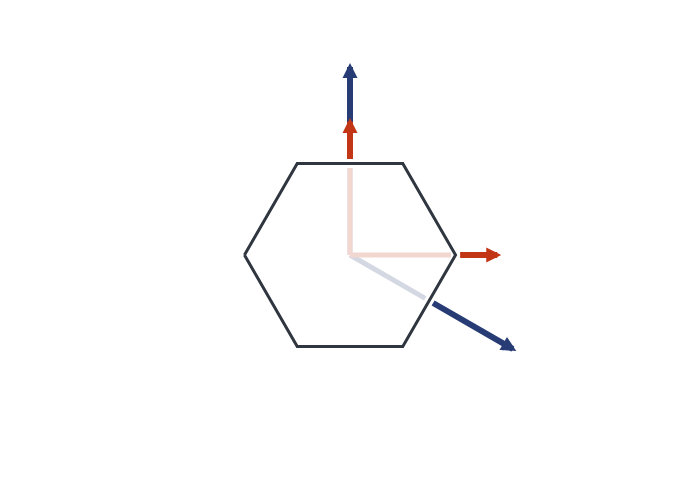

In [8]:
function make_cartesian(vecs, basis)
    """
    Calculates for each v in vectors, v1 * basis[1, :] + v2 * basis[2, :]
        This transforms from the reduced coordinates (w.r.t basis) to the cartesian coordinates 
    """
    cvecs = similar(vecs)
    for (i, v) in enumerate(vecs)
        cvecs[i] = basis' * v
    end
    cvecs
end


let 
    print("--- Plotting the Wigner-Seitz cell in reciprocal space. \n")
    print("\n")

    Bs = [G[i, :] for i ∈ 1 : size(G, 1)]
    recip_wignerseitz = wignerseitz(Bs)

    vertices = recip_wignerseitz.verts
    print("--- Vertices of the reciprocal Wigner-Seitz cell (in reduced coordinates): \n")
    for v ∈ vertices
        @printf("%10f %10f \n", v[1], v[2])
    end


    cvecs = make_cartesian(vertices, Bs)

    print("\n")
    print("--- Vertices of the reciprocal Wigner-Seitz cell (in cartesian coordinates): \n")
    for v ∈ cvecs
        @printf("%10f %10f \n", v[1], v[2])
    end


    pbzb = PlotlyJS.plot(recip_wignerseitz)
    display(pbzb)
end

In [9]:
# Let us calculate the cartesian coordinates of the M point 
global const K::Vector{Float64} = [2.094395, 0.0]; 
global const M::Vector{Float64} = (K + C_6 * K) / 2.0;

In [10]:

# Now, the K-Points 
global const high_symmetry_points = Dict{String, Vector{Float64}}(
    "K"=> K, 
    "M"=> M,
    "Γ"=> [0.0, 0.0] 
)

global const kpath_nodes::Vector{Vector{Float64}} = [high_symmetry_points["Γ"], 
                    high_symmetry_points["K"], 
                    high_symmetry_points["M"], 
                    high_symmetry_points["Γ"]];

# Now, construct the K-Path using linear interpolation. Will directly use the function provided in the Brillouin.jl package 
global const npts_kpath::Int64 = 500
global const kpath_fbz::Vector{Vector{Float64}} = interpolate(kpath_nodes, npts_kpath);


function plot_simple_kagome_bands(;t1::Float64, t2::Float64, u1::Float64, u2::Float64, B::Float64 = 0.0, 
            seedname::String = "", title = Nothing, save::Bool = false, kpath_fbz::Vector{Vector{Float64}} = kpath_fbz)
    if title == Nothing
        title = seedname
    end
    eks = evals.(kpath_fbz, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(B))

    nps_x = size(kpath_fbz, 1)
    xs = 1 : nps_x
    
    t1 = PlotlyJS.scatter(x = xs, y = map(e->e[1], eks), mode = "lines", line = attr(color = "purple", width = 4))
    t2 = PlotlyJS.scatter(x = xs, y = map(e->e[2], eks), mode = "lines", line = attr(color = "purple", width = 4))
    t3 = PlotlyJS.scatter(x = xs, y = map(e->e[3], eks), mode = "lines", line = attr(color = "purple", width = 4))
    t4 = PlotlyJS.scatter(x = xs, y = map(e->e[4], eks), mode = "lines", line = attr(color = "purple", width = 4))
    t5 = PlotlyJS.scatter(x = xs, y = map(e->e[5], eks), mode = "lines", line = attr(color = "purple", width = 4))
    t6 = PlotlyJS.scatter(x = xs, y = map(e->e[6], eks), mode = "lines", line = attr(color = "purple", width = 4))
    lo = PlotlyJS.Layout(title = title,
                xaxis_showgrid = true,
                yaxis_showgrid = true,
                plot_bgcolor="rgba(0,0,0,0)",
                xaxis = attr(showgrid = true, showticklabels = false, linecolor = "black", linewidth = 5, showline = true, mirror = true),
                yaxis = attr(showgrid = true, showticklabels = true, linecolor = "black", linewidth = 5, showline = true, mirror = true),
                width = 510, 
                height = 510,
                showlegend = false)
    
    p = PlotlyJS.plot([t1, t2, t3, t4, t5, t6], lo)
    if save == true
        PlotlyJS.savefig(p, assets_dir * seedname * ".png")
    end
    
    display(p)
end

plot_simple_kagome_bands (generic function with 1 method)

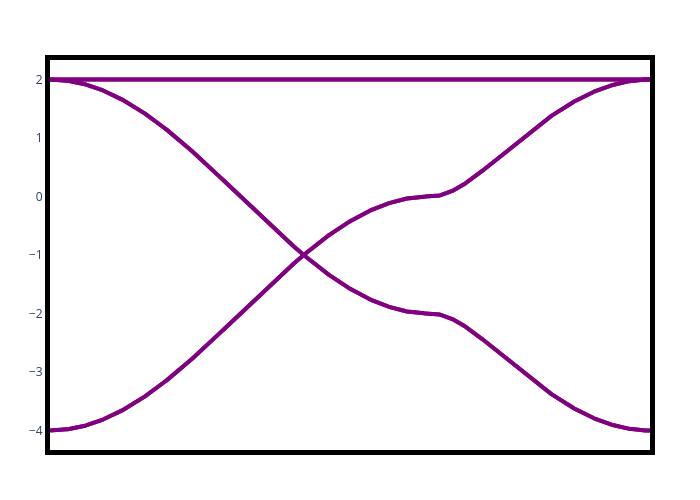

In [11]:
plot_simple_kagome_bands(t1 = 1.0, t2 = 0.0, u1 = 0.0, u2 = 0.0)

### Next, check what will happens if we turn on the background magnetic field ---> Zeemann split of the bands 

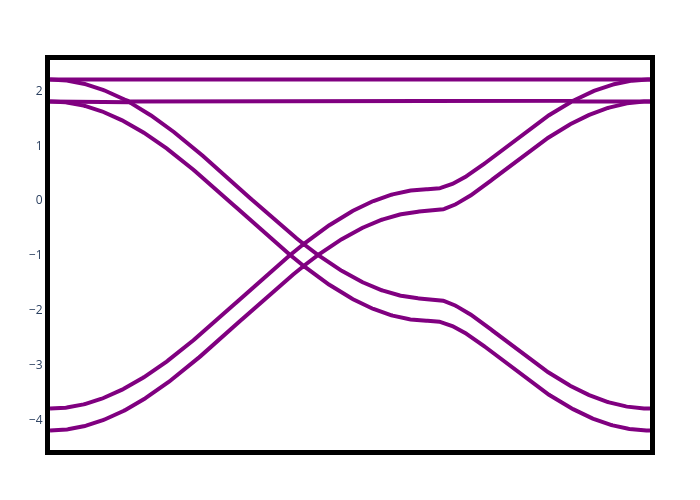

In [12]:
plot_simple_kagome_bands(t1 = 1.0, t2 = 0.0, u1 = 0.0, u2 = 0.0, B = 0.1)

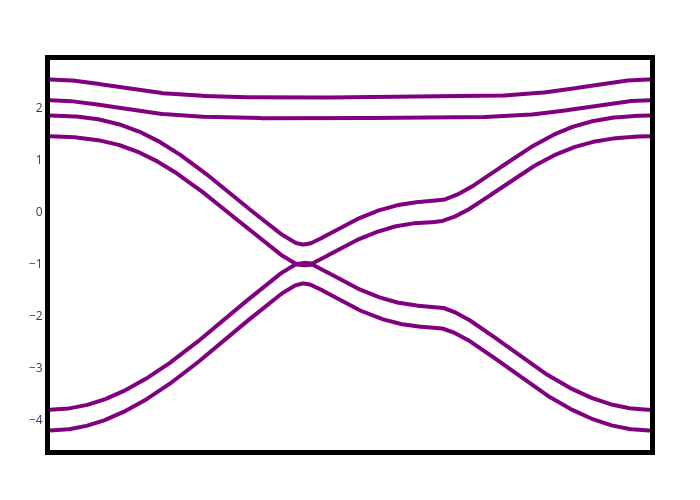

In [13]:
plot_simple_kagome_bands(t1 = 1.0, t2 = 0.0, u1 = 0.1, u2 = 0.0, B = 0.1)

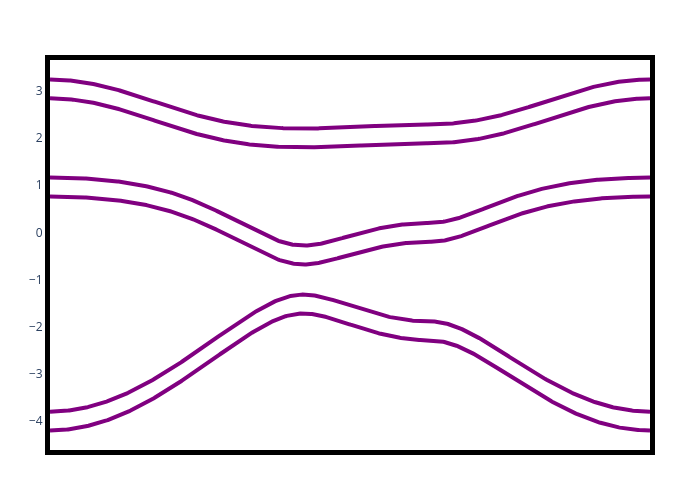

In [17]:
plot_simple_kagome_bands(t1 = 1.0, t2 = 0.0, u1 = 0.3, u2 = 0.0, B = 0.1)

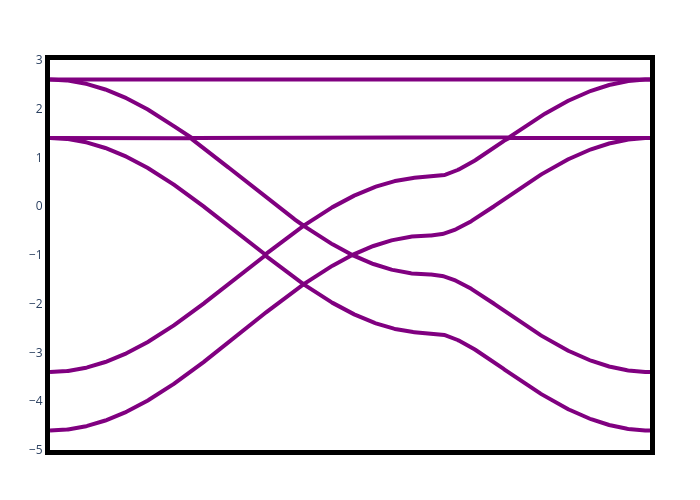

In [14]:
plot_simple_kagome_bands(t1 = 1.0, t2 = 0.0, u1 = 0.0, u2 = 0.0, B = 0.3)

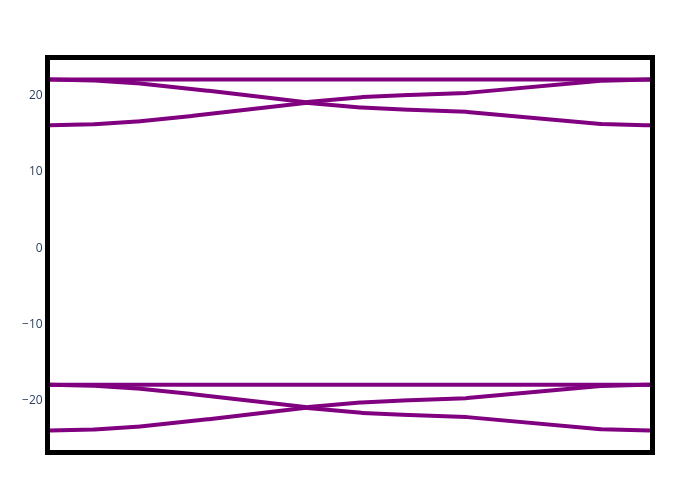

In [15]:
plot_simple_kagome_bands(t1 = 1.0, t2 = 0.0, u1 = 0.0, u2 = 0.0, B = 10.0)